In [1]:
# =============================================================================
# 1. Import Necessary Libraries
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import shap
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [2]:
# Set a distinct plotting style (new style)
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_theme(style="dark", palette="mako")
plt.rcParams['figure.figsize'] = (10, 6)

In [4]:
# =============================================================================
# 2. Data Loading and Exploration
# =============================================================================
# Load the Telecom Churn dataset (assume it's saved as "telecom_churn.csv")
df = pd.read_csv("/content/telecom_churn_data.csv")
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

Dataset Shape: (7043, 21)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  P

In [5]:
print("\nMissing Values per Column:")
print(df.isnull().sum())


Missing Values per Column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [6]:
# =============================================================================
# 3. Data Preprocessing
# =============================================================================
# Drop non-predictive columns (e.g., customerID)
if "customerID" in df.columns:
    df.drop(columns=["customerID"], inplace=True)

# Convert the target column "Churn" from "Yes"/"No" to binary (1 for Yes, 0 for No)
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# Some columns (e.g., TotalCharges) may be read as object due to formatting; convert them to numeric
if df["TotalCharges"].dtype == "object":
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
    df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


<ipython-input-6-d47e538a5b33>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


In [7]:
# Define numerical and categorical features.
# For this telecom dataset, assume the following:
numerical_features = ["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]
categorical_features = [col for col in df.columns if col not in numerical_features + ["Churn"]]

# Convert categorical features to type object if needed
df[categorical_features] = df[categorical_features].astype("object")

In [8]:
# Create a ColumnTransformer to scale numerical features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features)
    ]
)
X_processed = preprocessor.fit_transform(df.drop(columns=["Churn"]))
y = df["Churn"]


In [9]:
# Get feature names for later visualization
ohe = preprocessor.named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)
all_features = np.concatenate([numerical_features, ohe_feature_names])
# Convert X_processed to a DataFrame (dense if sparse)
X_df = pd.DataFrame(X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed, columns=all_features)
print("\nProcessed Feature Columns:")
print(X_df.columns)


Processed Feature Columns:
Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')


In [10]:
# =============================================================================
# 4. Train-Test Split
# =============================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.20, random_state=42, stratify=y
)
print("\nTraining Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)


Training Set Shape: (5634, 30)
Test Set Shape: (1409, 30)


In [11]:
# =============================================================================
# 5. Model Training using Random Forest with GridSearchCV
# =============================================================================
rf_clf = RandomForestClassifier(random_state=42)
param_grid = {
    "n_estimators": [100, 150],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}
grid = GridSearchCV(estimator=rf_clf, param_grid=param_grid, scoring="accuracy", cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print("\nBest Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)

best_model = grid.best_estimator_


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.8010271063402579


In [12]:
# =============================================================================
# 6. Model Evaluation
# =============================================================================
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409



In [13]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[933 102]
 [175 199]]


In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.841208762820016


In [15]:
# =============================================================================
# 7. Advanced Visualizations
# =============================================================================

## 7.1 Interactive ROC Curve using Plotly Express (New Visual Style)
roc_data = pd.DataFrame({"FPR": fpr, "TPR": tpr})
fig_px = px.area(roc_data, x="FPR", y="TPR", title=f"Interactive ROC Curve (AUC = {roc_auc:.3f})",
                 labels={"FPR": "False Positive Rate", "TPR": "True Positive Rate"},
                 hover_data={"FPR":":.3f", "TPR":":.3f"})
fig_px.add_scatter(x=[0, 1], y=[0, 1], mode="lines", name="Baseline", line=dict(dash="dash", color="black"))
fig_px.update_layout(template="plotly_white")
fig_px.show()


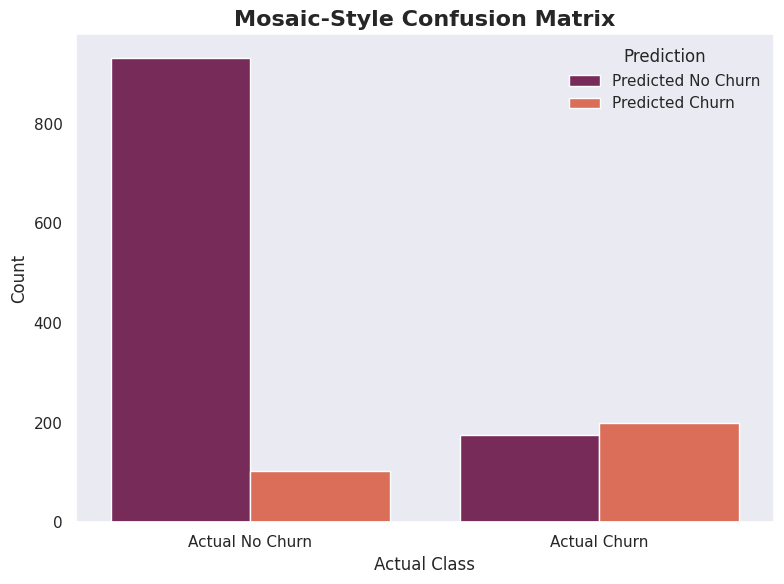

In [16]:
## 7.2 Mosaic-Style Bar Chart for Confusion Matrix using Seaborn
cm_df = pd.DataFrame(cm, index=["Actual No Churn", "Actual Churn"], columns=["Predicted No Churn", "Predicted Churn"])
cm_melt = cm_df.reset_index().melt(id_vars="index", var_name="Prediction", value_name="Count")
cm_melt.rename(columns={"index": "Actual"}, inplace=True)
plt.figure(figsize=(8,6))
sns.barplot(x="Actual", y="Count", hue="Prediction", data=cm_melt, palette="rocket")
plt.title("Mosaic-Style Confusion Matrix", fontsize=16, fontweight="bold")
plt.xlabel("Actual Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Prediction")
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

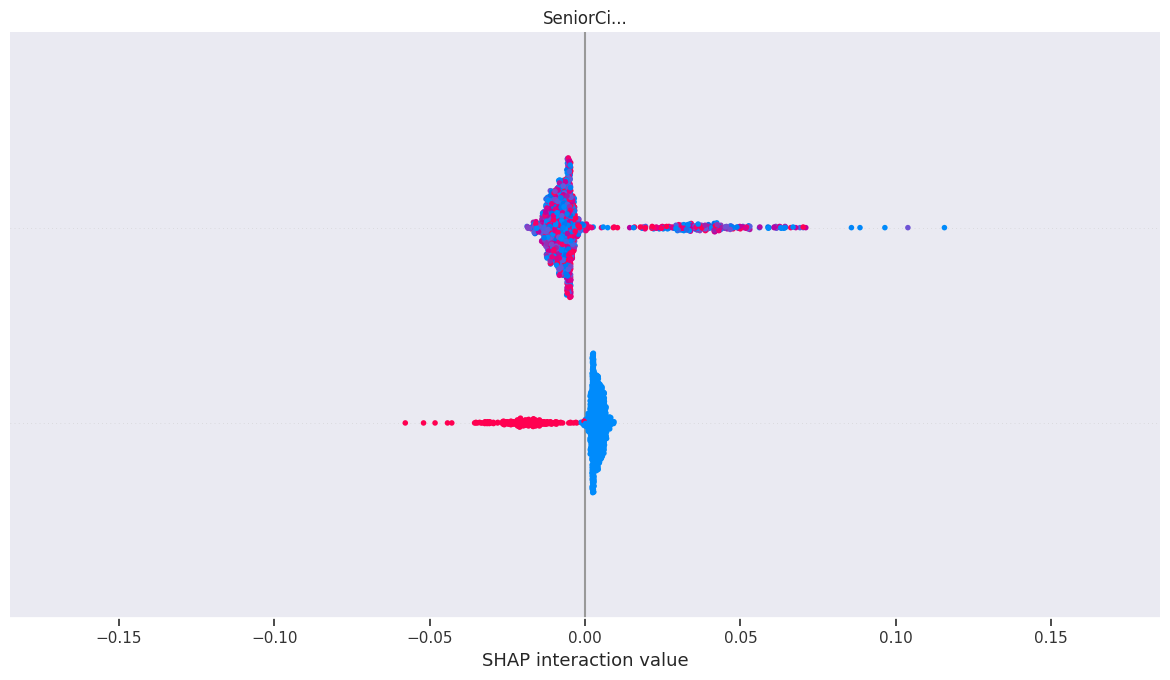

In [17]:
## 7.3 SHAP Beeswarm Plot for Feature Importance
# Use TreeExplainer with the RandomForest model
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="dot")


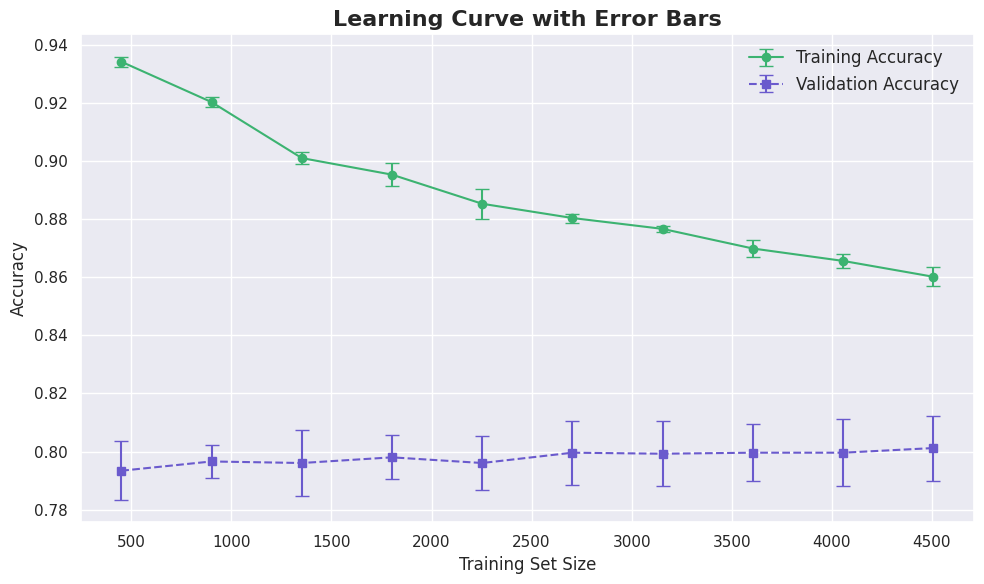

In [18]:
## 7.4 Learning Curve with Error Bars using scikit-learn
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(best_model, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10,6))
plt.errorbar(train_sizes, train_scores_mean, yerr=train_scores_std, label="Training Accuracy", fmt='o-', color="mediumseagreen", capsize=5)
plt.errorbar(train_sizes, val_scores_mean, yerr=val_scores_std, label="Validation Accuracy", fmt='s--', color="slateblue", capsize=5)
plt.title("Learning Curve with Error Bars", fontsize=16, fontweight="bold")
plt.xlabel("Training Set Size", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()